In [1]:
# Add environment Packages paths to conda
import os, sys, warnings
import pandas as pd
import numpy as np
warnings.simplefilter("ignore")

# Text preprocessing packages
import nltk # Text libarary
# nltk.download('stopwords')
import string # Removing special characters {#, @, ...}
import re # Regex Package
import regex
import emoji
# Corpora is a group presenting multiple collections of text documents. A single collection is called corpus.
from nltk.corpus import stopwords # Stopwords
import arabicstopwords.arabicstopwords as stp #more range of arabic stop words
from nltk.stem.isri import ISRIStemmer
from nltk.tokenize import word_tokenize

import pyarabic.araby as araby
from tashaphyne.stemming import ArabicLightStemmer

from nltk.stem import SnowballStemmer, WordNetLemmatizer # Stemmer & Lemmatizer
#from gensim.utils import simple_preprocess  # Text ==> List of Tokens

# Text Embedding
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from camel_tools.tokenizers.word import simple_word_tokenize
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np
from sklearn.model_selection import train_test_split

# Modelling
from sklearn.model_selection import train_test_split,KFold, GridSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score,confusion_matrix, classification_report
from sklearn.pipeline import Pipeline
from sklearn.metrics import f1_score
from sklearn.svm import SVC
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import EarlyStopping


# Saving Model
import pickle

# Visualization Packages
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(font_scale=1.3)
%matplotlib inline

In [2]:
train_p=pd.read_csv('train_Arabic_tweets_positive_20190413.tsv',sep='\t')
train_n=pd.read_csv('train_Arabic_tweets_negative_20190413.tsv',sep='\t')

test_p=pd.read_csv('test_Arabic_tweets_positive_20190413.tsv',sep='\t')
test_n=pd.read_csv('test_Arabic_tweets_negative_20190413.tsv',sep='\t')

In [3]:
print(f" train_n columns are {train_n.columns}")
print(f" train_p columns are {train_p.columns}")
print(f" test_p columns are {test_p.columns}")
print(f" test_n columns are {test_n.columns}")

 train_n columns are Index(['neg', 'اعترف ان بتس كانو شوي شوي يجيبو راسي لكن اليوم بالزايد 😭'], dtype='object')
 train_p columns are Index(['pos', 'نحن الذين يتحول كل ما نود أن نقوله إلى دعاء لله، لا تبحثوا فينا عن قوة، إننا مكسورون، القوة التي…'], dtype='object')
 test_p columns are Index(['pos', '#الهلال_الاهلي فوز هلالي مهم الحمد لله 💙 زوران كان بيسلم المباراة بعد تبديل كارييو بإنتظار الإتحاد بكرة يارب يار…'], dtype='object')
 test_n columns are Index(['neg', 'حتى الايتونز خربتوه مو صاحين انتو؟؟ 😭'], dtype='object')


In [4]:
train_p.rename(columns={'pos':'label' ,  'نحن الذين يتحول كل ما نود أن نقوله إلى دعاء لله، لا تبحثوا فينا عن قوة، إننا مكسورون، القوة التي…':'text'} , inplace=True)
train_n.rename(columns={'neg':'label' , 'اعترف ان بتس كانو شوي شوي يجيبو راسي لكن اليوم بالزايد 😭':'text' } , inplace=True)

test_p.rename(columns={'pos':'label' , '#الهلال_الاهلي فوز هلالي مهم الحمد لله 💙 زوران كان بيسلم المباراة بعد تبديل كارييو بإنتظار الإتحاد بكرة يارب يار…':'text'} , inplace=True)
test_n.rename(columns={'neg':'label' , 'حتى الايتونز خربتوه مو صاحين انتو؟؟ 😭':'text'} , inplace=True)

In [5]:
print(f" train_n columns are {train_n.columns}")
print(f" train_p columns are {train_p.columns}")
print(f" test_p columns are {test_p.columns}")
print(f" test_n columns are {test_n.columns}")

 train_n columns are Index(['label', 'text'], dtype='object')
 train_p columns are Index(['label', 'text'], dtype='object')
 test_p columns are Index(['label', 'text'], dtype='object')
 test_n columns are Index(['label', 'text'], dtype='object')


In [6]:
data = [train_p , train_n ,test_p , test_n]
for df in data:
    for cols in list(df.columns):
        if cols == 'pos' or cols == 'neg':
            print(f'{df} not builded well')
     

In [7]:
train_df = pd.concat([train_p , train_n])
train_df = train_df.sample(frac=1).reset_index(drop=True)


test_df = pd.concat([test_p , test_n])
test_df = test_df.sample(frac=1).reset_index(drop=True)

In [8]:
train_df

,label,text
0,pos,بمناسبة فوز الهلال .. 💙 سحب على آيفون XR📱 رتوي...
1,pos,#الاتحاد_النصر لاتحسبونا نسينا يالطواقي ولانبي...
2,neg,المفروض يكون ف حساب واحد ع كل موبايل يا تويتر ...
3,neg,فولو👇 والباك حالا 🔙 ⁦⁩ ⁦⁩ ⁦⁩ ⁦⁩⁦ ⁦⁩⁦…
4,neg,بجي اعوضكم معليش مكروفة بعرب ارمي هه
...,...,...
45268,neg,لا يارافا لا تكفى تكفى 😭
45269,neg,وضعي حاليا 😤 #الاتحاد_النصر
45270,neg,لا محبتهم 💖 تبنيلي قصر ⛪ و لا كرهم 💔يحفرلي قبر...
45271,neg,المفروض يكون الثالث بس ايش نسوي 💔 #BeautifulGo...


In [9]:
test_df

,label,text
0,pos,مايدري وش يسوي بفلوسه 😂
1,neg,ترى حظي نفس بوكريشه اللي بغى يصور سيلفي معاها ...
2,neg,يا اخوانا و الله لسة مطالبنا ما أتحقق منها غير...
3,neg,حسافه على جودة التعليم 😭
4,neg,يارب انا تايه دلني 💔 دعواتكم ليا فضلا وليس امر...
...,...,...
11513,pos,لست بالقوة التي تتخيلها، إنما انا لا أبالي بمع...
11514,neg,صباح الخير ✋
11515,neg,النطع دا اللي اتقفل حسابه من شويه دخل بحساب تا...
11516,neg,الاغانى دى بحبها جدا بحب المود بتاعها اووى 💔 ج...


In [10]:
train_df.isnull().sum()

label    0
text     0
dtype: int64

In [11]:
test_df.isnull().sum()

label    0
text     0
dtype: int64

In [12]:
train_df.duplicated().sum()

15721

In [13]:
train_df.drop_duplicates(inplace=True)
train_df.duplicated().sum()

0

In [14]:
test_df.duplicated().sum()

2678

In [15]:
test_df.drop_duplicates(inplace=True)
test_df.duplicated().sum()

0

In [16]:
data = pd.concat([train_df , test_df])

data

,label,text
0,pos,بمناسبة فوز الهلال .. 💙 سحب على آيفون XR📱 رتوي...
1,pos,#الاتحاد_النصر لاتحسبونا نسينا يالطواقي ولانبي...
2,neg,المفروض يكون ف حساب واحد ع كل موبايل يا تويتر ...
3,neg,فولو👇 والباك حالا 🔙 ⁦⁩ ⁦⁩ ⁦⁩ ⁦⁩⁦ ⁦⁩⁦…
4,neg,بجي اعوضكم معليش مكروفة بعرب ارمي هه
...,...,...
11505,neg,البوماات اغاني 😭 قولو اسم شخص واحد يسوي مثلهمم😭😍
11506,neg,هذا الي حضن بوم شفته وكنت شاكه اذا هو او لا، م...
11507,pos,طفيت بس. تمسون في خير وهنا 💚
11511,neg,ترا مره بطفش لأني بقضيه لحالي 😞 فيه صحباتي بيج...


In [17]:
data.isnull().sum()

label    0
text     0
dtype: int64

In [18]:
data.to_csv('new_data.csv' , index=False)

In [19]:
data = data.reset_index(drop=True)

In [20]:
data.duplicated().sum()

2518

In [21]:
data.drop_duplicates(inplace=True)
data.duplicated().sum()

0

In [22]:
data.reset_index(drop=True, inplace = True)

In [23]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35874 entries, 0 to 35873
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   label   35874 non-null  object
 1   text    35874 non-null  object
dtypes: object(2)
memory usage: 560.7+ KB


In [24]:
data.label.value_counts()

label
neg    18409
pos    17465
Name: count, dtype: int64

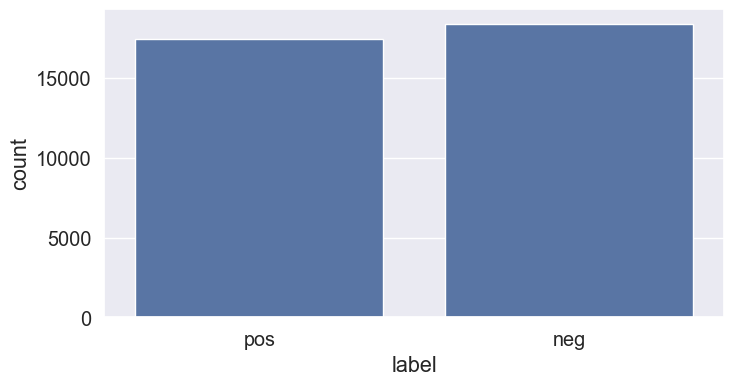

In [25]:
plt.figure(figsize=(8,4))
sns.countplot(x='label', data=data);

In [26]:
arabic_stopwords = stopwords.words("arabic")
len(arabic_stopwords)

754

In [27]:
data['stop_words'] = data['text'].apply(lambda x: len(set(x.split()) & set(arabic_stopwords)))
data.stop_words.value_counts()

stop_words
0     10489
1     10004
2      6524
3      3970
4      2384
5      1266
6       679
7       303
8       111
9        50
10       22
11        9
29        4
35        3
12        3
13        3
23        3
18        3
56        3
37        3
44        2
48        2
19        2
52        2
24        2
58        2
38        2
25        2
15        1
42        1
22        1
76        1
70        1
45        1
16        1
21        1
61        1
64        1
50        1
72        1
69        1
20        1
33        1
17        1
28        1
57        1
34        1
36        1
26        1
60        1
Name: count, dtype: int64

<Axes: ylabel='Frequency'>

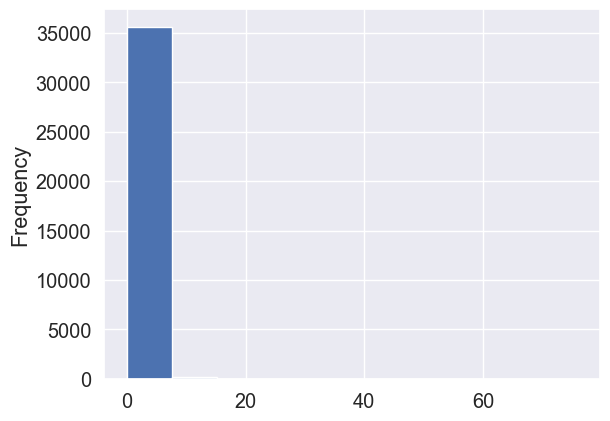

In [28]:
data['stop_words'].plot(kind= 'hist')

In [29]:
def emoji_counter(sentence):
    return emoji.emoji_count(sentence)

data['emoji_count'] = data['text'].apply(lambda x: emoji_counter(x))
data.emoji_count.value_counts()[:10]

emoji_count
1    24351
0     5082
2     2995
3     1653
4      742
5      423
6      199
7      120
8       70
9       41
Name: count, dtype: int64

In [30]:
emojis_data = data[data['emoji_count'] > 0]
emojis_data

,label,text,stop_words,emoji_count
0,pos,بمناسبة فوز الهلال .. 💙 سحب على آيفون XR📱 رتوي...,2,3
2,neg,المفروض يكون ف حساب واحد ع كل موبايل يا تويتر ...,5,1
3,neg,فولو👇 والباك حالا 🔙 ⁦⁩ ⁦⁩ ⁦⁩ ⁦⁩⁦ ⁦⁩⁦…,0,2
5,pos,ليه تدعي 😂,0,1
6,neg,إن لم تكونوا أوفياء ، فلا تعبثوا بقلوب الأنقياء 🥀,3,1
...,...,...,...,...
35869,neg,البوماات اغاني 😭 قولو اسم شخص واحد يسوي مثلهمم😭😍,1,3
35870,neg,هذا الي حضن بوم شفته وكنت شاكه اذا هو او لا، م...,4,1
35871,pos,طفيت بس. تمسون في خير وهنا 💚,1,1
35872,neg,ترا مره بطفش لأني بقضيه لحالي 😞 فيه صحباتي بيج...,3,1


In [31]:
def extract_emoji(text):
    import emoji
    emoji_list = []
    data = regex.findall(r'\X', text)
    for word in data:
        if any(emoji.distinct_emoji_list(char) for char in word):
            emoji_list.append(word)
    
    return emoji_list

In [32]:
emojis_data['emoji'] = emojis_data['text'].apply(lambda x: extract_emoji(x))
emojis_data['emoji'] = emojis_data['emoji'].apply(lambda x: ' '.join([word for word in x ]))

In [33]:
emojis_data

,label,text,stop_words,emoji_count,emoji
0,pos,بمناسبة فوز الهلال .. 💙 سحب على آيفون XR📱 رتوي...,2,3,💙 📱 💪
2,neg,المفروض يكون ف حساب واحد ع كل موبايل يا تويتر ...,5,1,😏
3,neg,فولو👇 والباك حالا 🔙 ⁦⁩ ⁦⁩ ⁦⁩ ⁦⁩⁦ ⁦⁩⁦…,0,2,👇 🔙
5,pos,ليه تدعي 😂,0,1,😂
6,neg,إن لم تكونوا أوفياء ، فلا تعبثوا بقلوب الأنقياء 🥀,3,1,🥀
...,...,...,...,...,...
35869,neg,البوماات اغاني 😭 قولو اسم شخص واحد يسوي مثلهمم😭😍,1,3,😭 😭 😍
35870,neg,هذا الي حضن بوم شفته وكنت شاكه اذا هو او لا، م...,4,1,😭
35871,pos,طفيت بس. تمسون في خير وهنا 💚,1,1,💚
35872,neg,ترا مره بطفش لأني بقضيه لحالي 😞 فيه صحباتي بيج...,3,1,😞


In [34]:
pd.Series(' '.join(emojis_data['emoji']).split()).value_counts()[:10]

💔    4492
😂    3910
😭    2289
🌹    1596
💙    1531
🤔    1167
😔    1110
❤    1089
🌚    1076
💛     952
Name: count, dtype: int64

In [35]:
emojis = {
    "🙂":"يبتسم",
    "😂":"يضحك",
    "💔":"قلب حزين",
    "🙂":"يبتسم",
    "❤️":"حب",
    "❤":"حب",
    "😍":"حب",
    "😭":"يبكي",
    "😢":"حزن",
    "😔":"حزن",
    "♥":"حب",
    "💜":"حب",
    "😅":"يضحك",
    "🙁":"حزين",
    "💕":"حب",
    "💙":"حب",
    "😞":"حزين",
    "😊":"سعادة",
    "👏":"يصفق",
    "👌":"احسنت",
    "😴":"ينام",
    "😀":"يضحك",
    "😌":"حزين",
    "🌹":"وردة",
    "🙈":"حب",
    "😄":"يضحك",
    "😐":"محايد",
    "✌":"منتصر",
    "✨":"نجمه",
    "🤔":"تفكير",
    "😏":"يستهزء",
    "😒":"يستهزء",
    "🙄":"ملل",
    "😕":"عصبية",
    "😃":"يضحك",
    "🌸":"وردة",
    "😓":"حزن",
    "💞":"حب",
    "💗":"حب",
    "😑":"منزعج",
    "💭":"تفكير",
    "😎":"ثقة",
    "💛":"حب",
    "😩":"حزين",
    "💪":"عضلات",
    "👍":"موافق",
    "🙏🏻":"رجاء طلب",
    "😳":"مصدوم",
    "👏🏼":"تصفيق",
    "🎶":"موسيقي",
    "🌚":"صمت",
    "💚":"حب",
    "🙏":"رجاء طلب",
    "💘":"حب",
    "🍃":"سلام",
    "☺":"يضحك",
    "🐸":"ضفدع",
    "😶":"مصدوم",
    "✌️":"مرح",
    "✋🏻":"توقف",
    "😉":"غمزة",
    "🌷":"حب",
    "🙃":"مبتسم",
    "😫":"حزين",
    "😨":"مصدوم",
    "🎼 ":"موسيقي",
    "🍁":"مرح",
    "🍂":"مرح",
    "💟":"حب",
    "😪":"حزن",
    "😆":"يضحك",
    "😣":"استياء",
    "☺️":"حب",
    "😱":"كارثة",
    "😁":"يضحك",
    "😖":"استياء",
    "🏃🏼":"يجري",
    "😡":"غضب",
    "🚶":"يسير",
    "🤕":"مرض",
    "‼️":"تعجب",
    "🕊":"طائر",
    "👌🏻":"احسنت",
    "❣":"حب",
    "🙊":"مصدوم",
    "💃":"سعادة مرح",
    "💃🏼":"سعادة مرح",
    "😜":"مرح",
    "👊":"ضربة",
    "😟":"استياء",
    "💖":"حب",
    "😥":"حزن",
    "🎻":"موسيقي",
    "✒":"يكتب",
    "🚶🏻":"يسير",
    "💎":"الماظ",
    "😷":"وباء مرض",
    "☝":"واحد",
    "🚬":"تدخين",
    "💐" : "ورد",
    "🌞" : "شمس",
    "👆" : "الاول",
    "⚠️" :"تحذير",
    "🤗" : "احتواء",
    "✖️": "غلط",
    "📍"  : "مكان",
    "👸" : "ملكه",
    "👑" : "تاج",
    "✔️" : "صح",
    "💌": "قلب",
    "😲" : "مندهش",
    "💦": "ماء",
    "🚫" : "خطا",
    "👏🏻" : "برافو",
    "🏊" :"يسبح",
    "👍🏻": "تمام",
    "⭕️" :"دائره كبيره",
    "🎷" : "ساكسفون",
    "👋": "تلويح باليد",
    "✌🏼": "علامه النصر",
    "🌝":"مبتسم",
    "➿"  : "عقده مزدوجه",
    "💪🏼" : "قوي",
    "📩":  "تواصل معي",
    "☕️": "قهوه",
    "😧" : "قلق و صدمة",
    "🗨": "رسالة",   
    "❗️" :"تعجب",
    "🙆🏻": "اشاره موافقه",
    "👯" :"اخوات",
    "©" :  "رمز",
    "👵🏽" :"سيده عجوزه",
    "🐣": "كتكوت",  
    "🙌": "تشجيع",
    "🙇": "شخص ينحني",
    "👐🏽":"ايدي مفتوحه",    
    "👌🏽": "بالظبط",
    "⁉️" : "استنكار",
    "⚽️": "كوره",
    "🕶" :"حب",
    "🎈" :"بالون",    
    "🎀":    "ورده",
    "💵":  "فلوس",   
    "😋":  "جائع",
    "😛":  "يغيظ",
    "😠":  "غاضب",
    "✍🏻":  "يكتب",
    "🌾":  "ارز",
    "👣":  "اثر قدمين",
    "❌":"رفض",
    "🍟":"طعام",
    "👬":"صداقة",
    "🐰":"ارنب",
    "☂":"مطر",
    "⚜":"مملكة فرنسا",
    "🐑":"خروف",
    "🗣":"صوت مرتفع",
    "👌🏼":"احسنت",
    "☘":"مرح",
    "😮":"صدمة",
    "😦":"قلق",
    "⭕":"الحق",
    "✏️":"قلم",
    "ℹ":"معلومات",
    "🙍🏻":"رفض",
    "⚪️":"نضارة نقاء",
    "🐤":"حزن",
    "💫":"مرح",
    "💝":"حب",
    "🍔":"طعام",
    "❤︎":"حب",
    "✈️":"سفر",
    "🏃🏻‍♀️":"يسير",
    "🍳":"ذكر",
    "🎤":"مايك غناء",
    "🎾":"كره",
    "🐔":"دجاجة",
    "🙋":"سؤال",
    "📮":"بحر",
    "💉":"دواء",
    "🙏🏼":"رجاء طلب",
    "💂🏿 ":"حارس",
    "🎬":"سينما",
    "♦️":"مرح",
    "💡":"قكرة",
    "‼":"تعجب",
    "👼":"طفل",
    "🔑":"مفتاح",
    "♥️":"حب",
    "🕋":"كعبة",
    "🐓":"دجاجة",
    "💩":"معترض",
    "👽":"فضائي",
    "☔️":"مطر",
    "🍷":"عصير",
    "🌟":"نجمة",
    "☁️":"سحب",
    "👃":"معترض",
    "🌺":"مرح",
    "🔪":"سكينة",
    "♨":"سخونية",
    "👊🏼":"ضرب",
    "✏":"قلم",
    "🚶🏾‍♀️":"يسير",
    "👊":"ضربة",
    "◾️":"وقف",
    "😚":"حب",
    "🔸":"مرح",
    "👎🏻":"لا يعجبني",
    "👊🏽":"ضربة",
    "😙":"حب",
    "🎥":"تصوير",
    "👉":"جذب انتباه",
    "👏🏽":"يصفق",
    "💪🏻":"عضلات",
    "🏴":"اسود",
    "🔥":"حريق",  
    "😬":"عدم الراحة",   
    "👊🏿":"يضرب",    
    "🌿":"ورقه شجره",     
    "✋🏼":"كف ايد",    
    "👐":"ايدي مفتوحه",      
    "☠️":"وجه مرعب",     
    "🎉":"يهنئ",      
    "🔕" :"صامت",
    "😿":"وجه حزين",      
    "☹️":"وجه يائس",     
    "😘" :"حب",     
    "😰" :"خوف و حزن",
    "🌼":"ورده",      
    "💋":  "بوسه",
    "👇":"لاسفل",     
    "❣️":"حب",     
    "🎧":"سماعات",
    "📝":"يكتب",      
    "😇":"دايخ",      
    "😈":"رعب",      
    "🏃":"يجري",      
    "✌🏻":"علامه النصر",    
    "🔫":"يضرب",      
    "❗️":"تعجب",
    "👎":"غير موافق",      
    "🔐":"قفل",      
    "👈":"لليمين",
    "™":"رمز",    
    "🚶🏽":"يتمشي",    
    "😯":"متفاجأ",  
    "✊":"يد مغلقه",    
    "😻":"اعجاب",    
    "🙉" :"قرد",    
    "👧":"طفله صغيره",     
    "🔴":"دائره حمراء",      
    "💪🏽":"قوه",     
    "💤":"ينام",     
    "👀":"ينظر",     
    "✍🏻":"يكتب",  
    "❄️":"تلج",
    "💀":"رعب",   
    "😤":"وجه عابس",      
    "🖋":"قلم",      
    "🎩":"كاب",      
    "☕️":"قهوه",     
    "😹":"ضحك",     
    "💓":"حب",      
    "☄️ ":"نار",     
    "👻":"رعب",
    }

emoticons_to_emoji = {
    ":)" : "🙂",
    ":(" : "🙁",
    "xD" : "😆",
    ":=(": "😭",
    ":'(": "😢",
    ":'‑(": "😢",
    "XD" : "😂",
    ":D" : "🙂",
    "♬" : "موسيقي",
    "♡" : "❤",
    "☻"  : "🙂",
    }

In [36]:
def remove_stop_words(text):
    Text=[i for i in str(text).split() if i not in arabic_stopwords]
    return " ".join(Text)

def ISRI_Stemmer(text):
    #making an object
    stemmer = ISRIStemmer()
    
    #stemming each word
    text = stemmer.stem(text)
    text = stemmer.pre32(text)
    text = stemmer.suf32(text)
    
    return text

def Snowball_stemmer(text):
    text = text.split()
    #making an object
    stemmer = SnowballStemmer("arabic")
    
    #stemming each word
    text=[stemmer.stem(y) for y in text]
    
    return " " .join(text)

def Arabic_Light_Stemmer(text):
    #making an object
    Arabic_Stemmer = ArabicLightStemmer()
    
    #stemming each word
    text=[Arabic_Stemmer.light_stem(y) for y in text.split()]
    
    return " " .join(text)

def normalizeArabic(text):
    text = text.strip()
    text = re.sub("ى", "ي", text)
    text = re.sub("ؤ", "ء", text)
    text = re.sub("ئ", "ء", text)
    text = re.sub("ة", "ه", text)
    
    #remove repetetions
    text = re.sub("[إأٱآا]", "ا", text)
    text = text.replace('وو', 'و')
    text = text.replace('يي', 'ي')
    text = text.replace('ييي', 'ي')
    text = text.replace('اا', 'ا')

    ## remove extra whitespace
    text = re.sub('\s+', ' ', text)
    
    # Remove longation
    text = re.sub(r'(.)\1+', r"\1\1", text) 
    
    #Strip vowels from a text, include Shadda.
    text = araby.strip_tashkeel(text)
    
    #Strip diacritics from a text, include harakats and small lettres The striped marks are
    text = araby.strip_diacritics(text)
    text=''.join([i for i in text if not i.isdigit()])
    return text

def Removing_non_arabic(text):
    text = re.sub('[A-Za-z]+',' ',text)
    return text

def Removing_numbers(text):
    text=''.join([i for i in text if not i.isdigit()])
    return text

def Removing_punctuations(text):
    ## Remove punctuations
    text = re.sub('[%s]' % re.escape("""!"#$%&'()*+,،-./:;<=>؟?@[\]^_`{|}~"""), ' ', text)
    text = text.replace('؛',"", )
    
    ## remove extra whitespace
    text = re.sub('\s+', ' ', text)
    text =  " ".join(text.split())
    return text.strip()

def Removing_urls(text):
    url_pattern = re.compile(r'https?://\S+|www\.\S+')
    return url_pattern.sub(r'', text)

def remove_emoji(string):
    
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', string).strip()

def remove_emoticons(text):
    emoticon_pattern = re.compile(u'(' + u'|'.join(k for k in EMOTICONS) + u')')
    return emoticon_pattern.sub(r'', text).strip()



def remove_extra_Space(text):
    ## remove extra whitespace
    text = re.sub('\s+', ' ', text)
    return  " ".join(text.split())

def remove_small_sentences(df):
    for i in range(len(df)):
        if len(df.text.iloc[i].split()) < 3:
            df.text.iloc[i] = np.nan
            
            
def replace_emoticon_with_emojis(text):
    for i in range (len(text)):
        message = text.iloc[i]
        seperarate_word = message.split(' ')
        cleaned_data.text.iloc[i] = ""

        for word in seperarate_word:
            text.iloc[i] += emoticons_to_emoji.get(word, word) + " "

def replace_emojis_with_text(text):
    for i in range (len(text)):
            message = text.iloc[i]
            seperarate_word = regex.findall(r'\X', message)
            text.iloc[i] = ""

            for word in seperarate_word:
                if any(emoji.distinct_emoji_list(char)  for char in word):
                        text.iloc[i] += " " + emojis.get(word, word) + " "
                else:
                        text.iloc[i] +=  emojis.get(word, word) + ""
            
    
            
def space_between_emojis(s): 
    return ''.join((' '+c+' ') if c in emoji.UNICODE_EMOJI['en'] else c for c in s)

def remove_hashtages_and_mentions(text):
    text = re.sub("@[A-Za-z0-9_]+","", text)
    text = re.sub("#[A-Za-z0-9_]+","", text)
    return text


In [37]:
cleaned_data = data

In [38]:
replace_emoticon_with_emojis(cleaned_data.text)
replace_emojis_with_text(cleaned_data.text)
cleaned_data.text=cleaned_data.text.apply(lambda text : Removing_non_arabic(text))
cleaned_data.text=cleaned_data.text.apply(lambda text : Removing_numbers(text))
cleaned_data.text=cleaned_data.text.apply(lambda text : remove_hashtages_and_mentions(text))
cleaned_data.text=cleaned_data.text.apply(lambda text : Removing_urls(text))
cleaned_data.text=cleaned_data.text.apply(lambda text : Removing_punctuations(text))

In [39]:
cleaned_data.text=cleaned_data.text.apply(lambda text : normalizeArabic(text))
cleaned_data.text=cleaned_data.text.apply(lambda text : remove_stop_words(text))

In [40]:
cleaned_data = cleaned_data.drop(columns=['stop_words' , 'emoji_count'])
cleaned_data

,label,text
0,pos,بمناسبه فوز الهلال حب سحب علي ايفون 📱 رتويت وت...
1,pos,الاتحاد النصر لاتحسبونا نسينا يالطواقي ولانبيك...
2,neg,المفروض يكون حساب موبايل تويتر يافيس واللي عند...
3,neg,فولو لاسفل والباك حالا 🔙 ⁦⁩ ⁦⁩ ⁦⁩ ⁦⁩⁦ ⁦⁩⁦…
4,neg,بجي اعوضكم معليش مكروفه بعرب ارمي هه
...,...,...
35869,neg,البومات اغاني يبكي قولو اسم شخص يسوي مثلهمم يب...
35870,neg,الي حضن بوم شفته وكنت شاكه اذا او مره فرحت عرف...
35871,pos,طفيت تمسون خير وهنا حب
35872,neg,ترا مره بطفش لاني بقضيه لحالي حزين صحباتي بيجت...


In [41]:
cleaned_data.text=cleaned_data.text.apply(lambda text : Arabic_Light_Stemmer(text))

In [42]:
cleaned_data.duplicated().sum()

451

In [43]:
index = cleaned_data[cleaned_data['text'].duplicated() == True].index
cleaned_data.drop(index, axis = 0, inplace = True)

#resetting the index of the data
cleaned_data.reset_index(drop=True, inplace = True)

In [44]:
cleaned_data.duplicated().sum()

0

In [45]:
remove_small_sentences(cleaned_data)

In [46]:
cleaned_data.isnull().sum()

label      0
text     625
dtype: int64

In [47]:
cleaned_data.dropna(inplace = True)

In [48]:
cleaned_data.reset_index(inplace=True)

In [49]:
cleaned_data.duplicated().sum()

0

In [50]:
X = cleaned_data['text']
y = cleaned_data['label']

In [51]:
y.value_counts()

label
neg    17895
pos    16772
Name: count, dtype: int64

In [52]:
print(X[:5])

print('#' * 50)

print(y[:5])

0    مناسب وز هلال حب سحب على يفو 📱 رتوي تابع سحب س...
1    اتحاد نصر اتحسب سي يالطواق انب وقف مع ماح حاجت...
2    مفروض كو حساب موبايل ويتر يافيس لي عند يس مينز...
3                  ول اسفل باك حال 🔙 ⁦⁩ ⁦⁩ ⁦⁩ ⁦⁩⁦ ⁦⁩⁦…
4                         جي عوض معليش مكروف عرب رم هه
Name: text, dtype: object
##################################################
0    pos
1    pos
2    neg
3    neg
4    neg
Name: label, dtype: object


In [53]:
le = LabelEncoder()
y = le.fit_transform(y)
y = pd.DataFrame(y, columns=['label'])
y

,label
0,1
1,1
2,0
3,0
4,0
...,...
34662,0
34663,0
34664,1
34665,0


In [54]:
cleaned_data.shape

(34667, 3)

In [55]:
# Number of examples to use for training
training_size = 30000

# Vocabulary size of the tokenizer
vocab_size = 15000

# Maximum length of the padded sequences
max_length = 100

# Output dimensions of the Embedding layer
embedding_dim = 64
lstm1_dim = 64
lstm2_dim = 32
lstm3_dim = 32
dense_dim = 32

In [56]:

training_sentences, testing_sentences, training_labels, testing_labels = train_test_split(
    X, y, train_size=0.95, random_state=42, shuffle=True
)


In [57]:
training_labels

,label
14535,0
26682,0
10122,1
32492,1
19966,0
...,...
16850,1
6265,1
11284,0
860,0


In [58]:
unique_labels = set(training_labels)
print(unique_labels)


{'label'}


In [59]:
training_labels = to_categorical(training_labels, num_classes=2)
testing_labels = to_categorical(testing_labels, num_classes=2)

In [60]:
vocab_size = 10000
max_length = 100
trunc_type = 'post'
padding_type = 'post'
oov_tok = "<OOV>"
training_size = 8000  


training_sentences = [' '.join(simple_word_tokenize(sentence)) for sentence in training_sentences]
testing_sentences = [' '.join(simple_word_tokenize(sentence)) for sentence in testing_sentences]

tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(training_sentences)
word_index = tokenizer.word_index

training_sequences = tokenizer.texts_to_sequences(training_sentences)
training_padded = pad_sequences(training_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

testing_sequences = tokenizer.texts_to_sequences(testing_sentences)
testing_padded = pad_sequences(testing_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

training_labels = np.array(training_labels)
testing_labels = np.array(testing_labels)



In [61]:
num_classes = len(np.unique(training_labels))
num_classes

2

In [62]:
training_padded.shape, training_labels.shape

((32933, 100), (32933, 2))

In [131]:
# trunc_type='post'
# padding_type='post'
# oov_tok = "<OOV>"


# tokenizer = Tokenizer(num_words=vocab_size , oov_token=oov_tok)
# tokenizer.fit_on_texts(training_sentences)
# word_index = tokenizer.word_index

# training_sequences = tokenizer.texts_to_sequences(training_sentences)
# training_padded = pad_sequences(training_sequences , maxlen=max_length ,padding=padding_type, truncating=trunc_type )

# testing_sequences = tokenizer.texts_to_sequences(testing_sentences)
# testing_padded = pad_sequences(testing_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

# training_labels = np.array(training_labels)
# testing_labels = np.array(testing_labels)


# def preprocess_arabic_text(text):
#     text = text.replace('أ', 'ا').replace('إ', 'ا').replace('آ', 'ا')
#     text = text.replace('ة', 'ه')
#     return text

# # Preprocess sentences
# training_sentences = [preprocess_arabic_text(sentence) for sentence in training_sentences]
# testing_sentences = [preprocess_arabic_text(sentence) for sentence in testing_sentences]

# # Tokenization
# tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)
# tokenizer.fit_on_texts(training_sentences)
# word_index = tokenizer.word_index

# # Convert text to sequences
# training_sequences = tokenizer.texts_to_sequences(training_sentences)
# training_padded = pad_sequences(training_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

# testing_sequences = tokenizer.texts_to_sequences(testing_sentences)
# testing_padded = pad_sequences(testing_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

# # Convert labels to numpy arrays
# training_labels = np.array(training_labels)
# testing_labels = np.array(testing_labels)

In [73]:
vocab_size = len(tokenizer.word_index) + 1

model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim),
    
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(lstm1_dim, return_sequences=True)),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.BatchNormalization(),
    
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(lstm2_dim)),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.BatchNormalization(),
    
    tf.keras.layers.Dense(dense_dim, activation='relu' , kernel_regularizer=regularizers.l2(0.01)),
    tf.keras.layers.Dropout(0.3),
    
    tf.keras.layers.Dense(2, activation='softmax')
])

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
              loss='categorical_crossentropy',
              metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 64)          1754048   
                                                                 
 bidirectional (Bidirectiona  (None, None, 128)        66048     
 l)                                                              
                                                                 
 dropout (Dropout)           (None, None, 128)         0         
                                                                 
 batch_normalization (BatchN  (None, None, 128)        512       
 ormalization)                                                   
                                                                 
 bidirectional_1 (Bidirectio  (None, 64)               41216     
 nal)                                                            
                                                        

In [74]:
NUM_EPOCHS = 10

history = model.fit(training_padded, training_labels, epochs=NUM_EPOCHS, validation_data=(testing_padded, testing_labels), verbose=2)

Epoch 1/10
1030/1030 - 53s - loss: 0.9289 - accuracy: 0.7314 - val_loss: 0.6262 - val_accuracy: 0.8674 - 53s/epoch - 52ms/step
Epoch 2/10
1030/1030 - 44s - loss: 0.5766 - accuracy: 0.8825 - val_loss: 0.5584 - val_accuracy: 0.8512 - 44s/epoch - 43ms/step
Epoch 3/10
1030/1030 - 42s - loss: 0.4401 - accuracy: 0.9065 - val_loss: 0.4429 - val_accuracy: 0.8910 - 42s/epoch - 41ms/step
Epoch 4/10
1030/1030 - 42s - loss: 0.3515 - accuracy: 0.9217 - val_loss: 0.4546 - val_accuracy: 0.8737 - 42s/epoch - 41ms/step
Epoch 5/10
1030/1030 - 44s - loss: 0.2835 - accuracy: 0.9321 - val_loss: 0.3777 - val_accuracy: 0.8847 - 44s/epoch - 43ms/step
Epoch 6/10
1030/1030 - 42s - loss: 0.2393 - accuracy: 0.9377 - val_loss: 0.5314 - val_accuracy: 0.8374 - 42s/epoch - 41ms/step
Epoch 7/10
1030/1030 - 39s - loss: 0.2021 - accuracy: 0.9457 - val_loss: 0.5872 - val_accuracy: 0.8281 - 39s/epoch - 38ms/step
Epoch 8/10
1030/1030 - 42s - loss: 0.1731 - accuracy: 0.9499 - val_loss: 0.4601 - val_accuracy: 0.8783 - 42s/ep

In [75]:
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

history = model.fit(training_padded, training_labels, epochs=10, validation_data=(testing_padded, testing_labels), callbacks=[early_stopping])


Epoch 1/10
1030/1030 [==============================] - 45s 43ms/step - loss: 0.1211 - accuracy: 0.9623 - val_loss: 0.5083 - val_accuracy: 0.8731
Epoch 2/10
1030/1030 [==============================] - 42s 41ms/step - loss: 0.1124 - accuracy: 0.9644 - val_loss: 0.5287 - val_accuracy: 0.8731
Epoch 3/10
1030/1030 [==============================] - 47s 46ms/step - loss: 0.0991 - accuracy: 0.9672 - val_loss: 0.5454 - val_accuracy: 0.8777
Epoch 4/10
1030/1030 [==============================] - 45s 43ms/step - loss: 0.0899 - accuracy: 0.9706 - val_loss: 0.5566 - val_accuracy: 0.8668


In [76]:
history_additional = model.fit(training_padded, training_labels, epochs=10, validation_data=(testing_padded, testing_labels), callbacks=[early_stopping])

Epoch 1/10
1030/1030 [==============================] - 44s 42ms/step - loss: 0.1105 - accuracy: 0.9645 - val_loss: 0.5114 - val_accuracy: 0.8777
Epoch 2/10
1030/1030 [==============================] - 44s 43ms/step - loss: 0.0981 - accuracy: 0.9679 - val_loss: 0.5452 - val_accuracy: 0.8743
Epoch 3/10
1030/1030 [==============================] - 45s 44ms/step - loss: 0.0917 - accuracy: 0.9700 - val_loss: 0.5677 - val_accuracy: 0.8697
Epoch 4/10
1030/1030 [==============================] - 48s 46ms/step - loss: 0.0804 - accuracy: 0.9737 - val_loss: 0.6188 - val_accuracy: 0.8691


In [77]:
for key in history.history.keys():
    history.history[key] += history_additional.history[key]


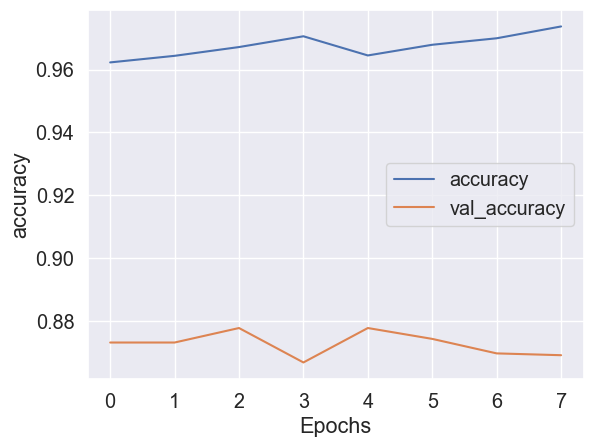

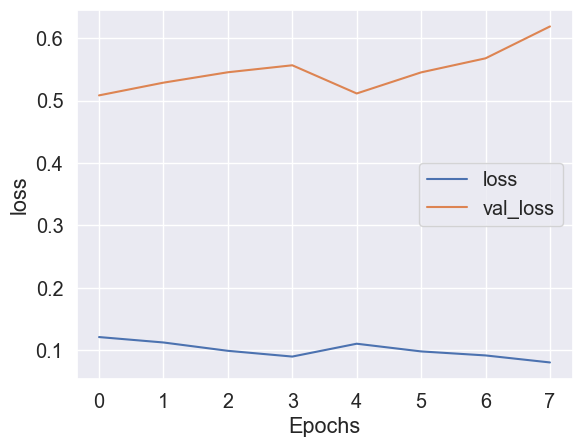

In [78]:
import matplotlib.pyplot as plt

# Plot utility
def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()

# Plot the accuracy and results 
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

In [81]:
true_labels = np.argmax(testing_labels, axis=1)
predicted_probabilities = model.predict(testing_padded)
predicted_labels = np.argmax(predicted_probabilities, axis=1)


55/55 [==============================] - 2s 21ms/step


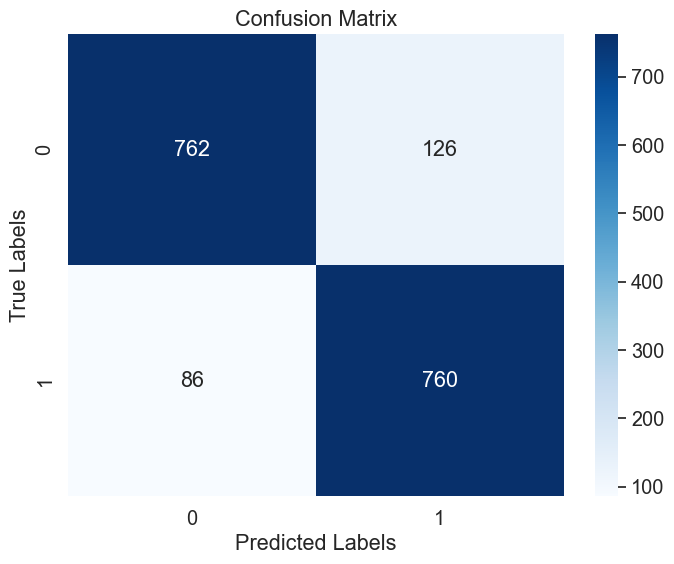

In [82]:

true_labels = np.argmax(testing_labels, axis=1)

cm = confusion_matrix(true_labels, predicted_labels)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()


In [83]:
model.save("Arabic_senti.h5")

In [72]:
import tensorflow as tf
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import EarlyStopping
import mlflow
import mlflow.keras
import json
import os

# Ensure these variables are defined
embedding_dim = 128  # Set your embedding dimension
lstm1_dim = 64       # Set LSTM layer 1 units
lstm2_dim = 64       # Set LSTM layer 2 units
dense_dim = 64       # Set Dense layer units
NUM_EPOCHS = 10      # Set the number of epochs

# Set MLflow tracking URI and experiment
mlflow.set_tracking_uri("https://dagshub.com/asamy4194/DEPI_Final_Project.mlflow")
mlflow.set_experiment(experiment_id=2)

import os
os.environ['MLFLOW_TRACKING_USERNAME'] = 'asamy4194' # 'learnpythonlanguage'
os.environ['MLFLOW_TRACKING_PASSWORD'] = '951cd23d2b7cec538703bd36d2e2fbef6a209ec8' #
os.environ['MLFLOW_TRACKING_URI'] = 'https://dagshub.com/asamy4194/DEPI_Final_Project.mlflow' # https://dagshub.com/learnpythonlanguage/mlflow_dagshub_demo.mlflow


# Model definition
vocab_size = len(tokenizer.word_index) + 1  # Ensure 'tokenizer' is defined

model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim),
    
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(lstm1_dim, return_sequences=True)),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.BatchNormalization(),
    
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(lstm2_dim)),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.BatchNormalization(),
    
    tf.keras.layers.Dense(dense_dim, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    tf.keras.layers.Dropout(0.3),
    
    tf.keras.layers.Dense(2, activation='softmax')
])

# Compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Print model summary
model.summary()

# MLflow logging
with mlflow.start_run():
    # Log model parameters
    mlflow.log_param("vocab_size", vocab_size)
    mlflow.log_param("embedding_dim", embedding_dim)
    mlflow.log_param("lstm1_dim", lstm1_dim)
    mlflow.log_param("lstm2_dim", lstm2_dim)
    mlflow.log_param("dense_dim", dense_dim)
    mlflow.log_param("learning_rate", 1e-4)
    mlflow.log_param("dropout_rate", 0.3)
    
    # Early stopping callback
    early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

    # Train the model and log metrics
    history = model.fit(training_padded, training_labels, 
                        epochs=NUM_EPOCHS, 
                        validation_data=(testing_padded, testing_labels), 
                        callbacks=[early_stopping], 
                        verbose=2)
    
    # Log metrics
    for epoch, train_acc in enumerate(history.history['accuracy']):
        mlflow.log_metric('train_accuracy', train_acc, step=epoch)
    for epoch, val_acc in enumerate(history.history['val_accuracy']):
        mlflow.log_metric('val_accuracy', val_acc, step=epoch)

    # Log the model to MLflow
    mlflow.keras.log_model(model, "model")

    # Save training history to a JSON file and log it as an artifact
    history_file = "history.json"
    with open(history_file, 'w') as f:
        json.dump(history.history, f)
    mlflow.log_artifact(history_file)

    # End the MLflow run
    mlflow.end_run()

# Additional training, if needed
history_additional = model.fit(training_padded, training_labels, 
                               epochs=10, 
                               validation_data=(testing_padded, testing_labels), 
                               callbacks=[early_stopping])


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 128)         3511552   
                                                                 
 bidirectional (Bidirectiona  (None, None, 128)        98816     
 l)                                                              
                                                                 
 dropout (Dropout)           (None, None, 128)         0         
                                                                 
 batch_normalization (BatchN  (None, None, 128)        512       
 ormalization)                                                   
                                                                 
 bidirectional_1 (Bidirectio  (None, 128)              98816     
 nal)                                                            
                                                        

2024/10/17 15:18:40 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.


INFO:tensorflow:Assets written to: C:\Users\asamy\AppData\Local\Temp\tmpb75xal0y\model\data\model\assets


INFO:tensorflow:Assets written to: C:\Users\asamy\AppData\Local\Temp\tmpb75xal0y\model\data\model\assets
2024/10/17 15:19:15 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/10/17 15:21:08 INFO mlflow.tracking._tracking_service.client: 🏃 View run glamorous-hawk-503 at: https://dagshub.com/asamy4194/DEPI_Final_Project.mlflow/#/experiments/2/runs/8d5a17a32dc5463cbc21d49db57f2710.
2024/10/17 15:21:08 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: https://dagshub.com/asamy4194/DEPI_Final_Project.mlflow/#/experiments/2.


Epoch 1/10
1030/1030 [==============================] - 46s 44ms/step - loss: 0.2004 - accuracy: 0.9458 - val_loss: 0.3977 - val_accuracy: 0.8858
Epoch 2/10
1030/1030 [==============================] - 44s 43ms/step - loss: 0.1564 - accuracy: 0.9537 - val_loss: 0.4586 - val_accuracy: 0.8743
Epoch 3/10
1030/1030 [==============================] - 43s 41ms/step - loss: 0.1311 - accuracy: 0.9588 - val_loss: 0.4730 - val_accuracy: 0.8864
Epoch 4/10
1030/1030 [==============================] - 41s 40ms/step - loss: 0.1141 - accuracy: 0.9631 - val_loss: 0.4662 - val_accuracy: 0.8847


In [73]:
model.save("mlflow_model.h5")

In [74]:
import tensorflow as tf
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import EarlyStopping
import mlflow
import mlflow.keras
import json
import os

# Set MLflow tracking URI and experiment
mlflow.set_tracking_uri("https://dagshub.com/asamy4194/DEPI_Final_Project.mlflow")
mlflow.set_experiment(experiment_id=2)

os.environ['MLFLOW_TRACKING_USERNAME'] = 'asamy4194'
os.environ['MLFLOW_TRACKING_PASSWORD'] = '951cd23d2b7cec538703bd36d2e2fbef6a209ec8'

# Define model parameters
embedding_dim = 128
filters = 128  # Number of filters for Conv1D layers
kernel_size = 5  # Kernel size for Conv1D
dense_dim = 64
NUM_EPOCHS = 10

# CNN Model Definition
model_cnn = tf.keras.Sequential([
    tf.keras.layers.Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=training_padded.shape[1]),
    
    tf.keras.layers.Conv1D(filters=filters, kernel_size=kernel_size, activation='relu'),
    tf.keras.layers.GlobalMaxPooling1D(),
    
    tf.keras.layers.Dense(dense_dim, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    tf.keras.layers.Dropout(0.3),
    
    tf.keras.layers.Dense(2, activation='softmax')
])

# Compile the model
model_cnn.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

# Print model summary
model_cnn.summary()

# MLflow logging for the CNN model
with mlflow.start_run(run_name="CNN Model"):
    # Log model parameters
    mlflow.log_param("vocab_size", vocab_size)
    mlflow.log_param("embedding_dim", embedding_dim)
    mlflow.log_param("filters", filters)
    mlflow.log_param("kernel_size", kernel_size)
    mlflow.log_param("dense_dim", dense_dim)
    mlflow.log_param("learning_rate", 1e-4)
    mlflow.log_param("dropout_rate", 0.3)
    
    # Early stopping callback
    early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

    # Train the CNN model
    history_cnn = model_cnn.fit(training_padded, training_labels, 
                                epochs=NUM_EPOCHS, 
                                validation_data=(testing_padded, testing_labels), 
                                callbacks=[early_stopping], 
                                verbose=2)
    
    # Log training metrics
    for epoch, train_acc in enumerate(history_cnn.history['accuracy']):
        mlflow.log_metric('train_accuracy', train_acc, step=epoch)
    for epoch, val_acc in enumerate(history_cnn.history['val_accuracy']):
        mlflow.log_metric('val_accuracy', val_acc, step=epoch)

    # Log the CNN model
    mlflow.keras.log_model(model_cnn, "cnn_model")

    # Save the training history as a JSON file
    history_cnn_file = "cnn_history.json"
    with open(history_cnn_file, 'w') as f:
        json.dump(history_cnn.history, f)
    mlflow.log_artifact(history_cnn_file)

    # End the MLflow run
    mlflow.end_run()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 100, 128)          3511552   
                                                                 
 conv1d (Conv1D)             (None, 96, 128)           82048     
                                                                 
 global_max_pooling1d (Globa  (None, 128)              0         
 lMaxPooling1D)                                                  
                                                                 
 dense_2 (Dense)             (None, 64)                8256      
                                                                 
 dropout_3 (Dropout)         (None, 64)                0         
                                                                 
 dense_3 (Dense)             (None, 2)                 130       
                                                      

2024/10/17 15:25:01 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.


INFO:tensorflow:Assets written to: C:\Users\asamy\AppData\Local\Temp\tmpfc9khcqu\model\data\model\assets


INFO:tensorflow:Assets written to: C:\Users\asamy\AppData\Local\Temp\tmpfc9khcqu\model\data\model\assets
2024/10/17 15:25:09 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/10/17 15:26:39 INFO mlflow.tracking._tracking_service.client: 🏃 View run CNN Model at: https://dagshub.com/asamy4194/DEPI_Final_Project.mlflow/#/experiments/2/runs/9a366e4aa79a457fa7d584df24c38390.
2024/10/17 15:26:39 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: https://dagshub.com/asamy4194/DEPI_Final_Project.mlflow/#/experiments/2.


In [75]:
model.save("mlflow_model_2.h5")